# DFT on Alkali metals 

$$ \frac{4}{3} \pi R_c^3 \rho_b = N_e \quad \text{where} \quad \frac{4}{3} \pi r_s^3 \rho_b = 1 $$

\begin{equation}
    v_\text{ext}(r) = 2 \pi \rho_b \times \left\{
    \begin{aligned}
    & \frac{1}{3} r^2 - R_c^2 & \text{if} \; r \leq R_c \\
    & -\frac{2}{3} \frac{R_c^3}{r} & \text{if} \; r > R_c
    \end{aligned}\right.
\end{equation}


\begin{equation}
    \left(- \frac{\nabla^2}{2} + v_\text{eff} (\mathbf{r})\right) \varphi_i (\mathbf{r}) = \varepsilon_i \varphi_i(\mathbf{r})
\end{equation}

In [1]:
from IPython.display import Latex

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

from scipy.integrate import simpson

from matplotlib.backends.backend_pdf import PdfPages

dr = 0.05
npt = 1001
rgrid = np.arange(1, npt+1) * dr

# number of electrons in the cluster
N = [2, 8, 10, 20, 40]

# possible values of l for n electrons as in the list N
l_N = [[0], [0, 1], [0, 1], [0, 1, 2], [0, 1, 2, 3]]

# degeneracy of angular momentum levels
deg = [2, 6, 10, 14]

eta = 0.05

In [2]:
def v_ext(r, rs, N, l):
    rho_b = 3 / (4*np.pi) / rs**3
    Rc = (3*N /  (4*np.pi) / rho_b)**(1/3)
    
    if r <= Rc:
        return 2*np.pi*rho_b * (1/3*r**2 - Rc**2) + l*(l+1) / (2*r**2)
    return 2*np.pi*rho_b * (-2/3 * Rc**3 / r) + l*(l+1) / (2*r**2)

v_ext = np.vectorize(v_ext, excluded=[1, 2, 3])


def Numerov(rgrid, V, T=None, return_T=False):
    n = len(rgrid)
    dr = rgrid[1] - rgrid[0] 

    if T is None:
        A = np.eye(n, k=1) - 2*np.eye(n) +  np.eye(n, k=-1)
        A = A / dr**2
        
        B = np.eye(n, k=1) + 10*np.eye(n) +  np.eye(n, k=-1)
        Binv = np.linalg.inv(B / 12)
        
        T = - Binv.dot(A) / 2
    H = T + np.diag(V)
    if return_T:
        return *np.linalg.eigh(H), T
    return np.linalg.eigh(H)


# compute T matrix and use it all over again
e, wf, T = Numerov(rgrid, np.zeros(npt), return_T=True)


def normalize_psi(psi, x):
    psi_sq = simpson(abs(psi)**2, x)
    return psi / np.sqrt(psi_sq)

## 1. Na and K in the indipendent electron model

### Na

In [3]:
rs = 3.93 # a0

# one density for every value of N
rhoNa = np.zeros((5, npt))

for i, n in enumerate(N):
    # iterate over possible l values for n electrons
    for l in l_N[i]:
        # compute Vext on rgrid
        V = v_ext(rgrid, rs, n, l)
        # obtain energies and wave funtions via Numerov's method
        e, wf = Numerov(rgrid, V, T)
        
        rhoNa[i] += deg[l] * normalize_psi(wf[:, 0], rgrid)**2 / rgrid**2 / (4*np.pi)

        if (n > 8 and l == 0) or (n > 20 and l==1):
            rhoNa[i] += deg[l] * normalize_psi(wf[:, 1], rgrid)**2 / rgrid**2 / (4*np.pi)

### K

In [4]:
rs = 4.86 # a0

# one density for every value of N
rhoK = np.zeros((5, npt))

for i, n in enumerate(N):
    # iterate over possible l values for n electrons
    for l in l_N[i]:
        # compute Vext on rgrid
        V = v_ext(rgrid, rs, n, l)
        # obtain energies and wave funtions via Numerov's method
        e, wf = Numerov(rgrid, V, T)
        
        rhoK[i] += deg[l] * normalize_psi(wf[:, 0], rgrid)**2 / rgrid**2 / (4*np.pi)
        
        if (n > 8 and l == 0) or (n > 20 and l==1):
            rhoK[i] += deg[l] * normalize_psi(wf[:, 1], rgrid)**2 / rgrid**2 / (4*np.pi)

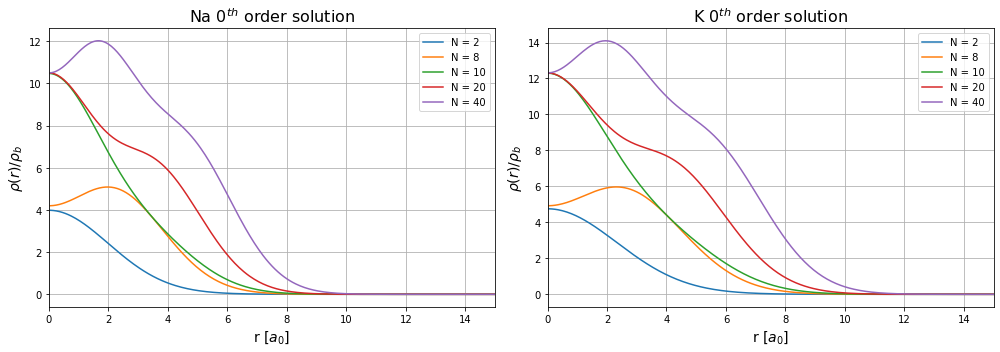

In [5]:
pdf = PdfPages('rho0.pdf')

plt.figure(figsize = (14, 5))

plt.subplot(121)

rs = 3.93 # a0
rho_b = 3 / (4*np.pi) / rs**3
for i, n in enumerate(N):
    plt.plot(rgrid, rhoNa[i]/rho_b, label=f'N = {n}')

plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\\rho(r) / \\rho_b$', fontsize=14)
plt.title('Na $0^{{th}}$ order solution', fontsize=16)
plt.xlim(0,15)
plt.legend()
plt.grid()

plt.subplot(122)

rs = 4.86 # a0
rho_b = 3 / (4*np.pi) / rs**3
for i, n in enumerate(N):
    plt.plot(rgrid, rhoK[i]/rho_b, label=f'N = {n}')

plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\\rho(r) / \\rho_b$', fontsize=14)
plt.title('K $0^{{th}}$ order solution', fontsize=16)
plt.xlim(0,15)
plt.legend()
plt.grid()

plt.tight_layout()

pdf.savefig()
plt.show()

pdf.close()

## 4. KS equations

\begin{equation}
    v_\text{eff} (\mathbf{r}) = v_\text{ext} (\mathbf{r}) + \int \frac{\rho(\mathbf{r}^\prime)}{|\mathbf{r} - \mathbf{r}^\prime |} d \mathbf{r}^\prime + \frac{\delta \epsilon_{\mathrm{xc}}(\rho(\mathbf{r}))}{\delta \rho(\mathbf{r})} + \epsilon_{\mathrm{xc}}(\rho(\mathbf{r}))
\end{equation}


\begin{equation}
\begin{aligned}
    & \epsilon_x =  -\frac{3}{4}\left(\frac{3}{\pi}\right)^{\frac{1}{3}} \rho(r)^{\frac{1}{3}}\\
    & \epsilon_c = -2 A\left(1+\alpha_{1} r_{s}\right) \ln \left[1+\frac{1}{2 A\left(\beta_{1} r_{s}^{1 / 2}+\beta_{2} r_{s}+\beta_{3} r_{s}^{3 / 2}+\beta_{4} r_{s}^{p+1}\right)}\right]
\end{aligned}
\end{equation}

In [6]:
A = 0.031091 
a1 = 0.21370 
b1 = 7.5957 
b2 = 3.5876 
b3 = 1.6382
b4 = 0.49294

In [7]:
# direct potential
def U(r, rho):
    # index of r on rgrid
    i = np.where(rgrid == r)[0][0]

    from_0_to_r = simpson(rgrid[:i+1]**2 * rho[:i+1], rgrid[:i+1]) / r
    from_r_to_infty = simpson(rgrid[i:]*rho[i:], rgrid[i:])
    
    return 4*np.pi * (from_0_to_r + from_r_to_infty)

U = np.vectorize(U, excluded=[1])


# rho must be an array or the point rho(r)
def epsilon_x(rho):
    return -3/4 * (3 / np.pi * rho)**(1/3)


# correlation potential (espilon c)
def G(rs):
    den = 2*A * (b1*rs**0.5 + b2*rs + b3*rs**1.5 + b4*rs**2)
    return -2*A * (1 + a1*rs) * np.log(1 + 1/den)


# rho must be an array: E_xc doesn't depend on r
def E_xc(rho):
    rs = (3 / (4*np.pi * rho))**(1/3)
    return 4*np.pi*simpson(rgrid**2*(epsilon_x(rho) + G(rs))*rho, rgrid)


# derivative of G on rs
def dG(rs):
    num = b2 + 0.5*b1/rs**0.5 + 1.5*b3*rs**0.5 + 2*b4*rs
    den = b1*rs**0.5 + b2*rs + b3*rs**1.5 + b4*rs**2
    return (1+a1*rs)*num/(den**2*(1 + 1/(2*A*den))) - 2*A*a1*np.log(1 + 1/(2*A*den))
    

# d(E_xc) / d(rho)
def v_xc(rho):
    rs = (3 / (4*np.pi * rho))**(1/3)
    return -(3/np.pi*rho)**(1/3) + G(rs) - (36*np.pi*rho)**(-1/3)*dG(rs)


# self consistent
def v_SF(r, rho):
    return U(r, rho) + v_xc(rho)

### Na

In [8]:
rs = 3.93 # a0

steps = 100

rho_Na = rhoNa[[1,3,4], :]

E_Na = np.zeros((3, steps))
for step in range(steps):
    rho = np.zeros((3, npt))
    for j, i in enumerate([1, 3, 4]):
        n = N[i]
        # compute self consistent potential
        Vsf = v_SF(rgrid, rho_Na[j])
        # iterate over possible l values for n electrons
        for l in l_N[i]:
            # compute Vext on rgrid
            V = v_ext(rgrid, rs, n, l) + Vsf
            # obtain energies and wave funtions via Numerov's method
            e, wf = Numerov(rgrid, V, T)

            rho[j] += deg[l] * normalize_psi(wf[:, 0], rgrid)**2  / rgrid**2 / (4*np.pi)
            E_Na[j, step] += deg[l] * e[0]

            if (n > 8 and l == 0) or (n > 20 and l==1):
                rho[j] += deg[l] * normalize_psi(wf[:, 1], rgrid)**2  / rgrid**2 / (4*np.pi)
                E_Na[j, step] += deg[l] * e[1]
                
    rho_Na = eta*rho + (1-eta)*rho_Na
    
    direct = np.zeros(3)
    for i in range(3):
        direct[i] = 0.5*4*np.pi*simpson(rgrid**2*rho[i]*U(rgrid, rho[i]), rgrid)

    E_Na[:, step] += -direct + E_xc(rho) - 4*np.pi*simpson(rgrid**2*rho*v_xc(rho), rgrid)

### K

In [9]:
rs = 4.86 # a0

steps = 100

rho_K = rhoK[[1,3,4], :]

E_K = np.zeros((3, steps))
for step in range(steps):
    rho = np.zeros((3, npt))
    for j, i in enumerate([1, 3, 4]):
        n = N[i]
        # compute self consistent potential
        Vsf = v_SF(rgrid, rho_K[j])
        # iterate over possible l values for n electrons
        for l in l_N[i]:
            # compute Vext on rgrid
            V = v_ext(rgrid, rs, n, l) + Vsf
            # obtain energies and wave funtions via Numerov's method
            e, wf = Numerov(rgrid, V, T)

            rho[j] += deg[l] * normalize_psi(wf[:, 0], rgrid)**2  / rgrid**2 / (4*np.pi)
            E_K[j, step] += deg[l] * e[0]

            if (n > 8 and l == 0) or (n > 20 and l==1):
                rho[j] += deg[l] * normalize_psi(wf[:, 1], rgrid)**2  / rgrid**2 / (4*np.pi)
                E_K[j, step] += deg[l] * e[1]
                
    rho_K = eta*rho + (1-eta)*rho_K
    
    direct = np.zeros(3)
    for i in range(3):
        direct[i] = 0.5*4*np.pi*simpson(rgrid**2*rho[i]*U(rgrid, rho[i]), rgrid)

    E_K[:, step] += -direct + E_xc(rho) - 4*np.pi*simpson(rgrid**2*rho*v_xc(rho), rgrid)

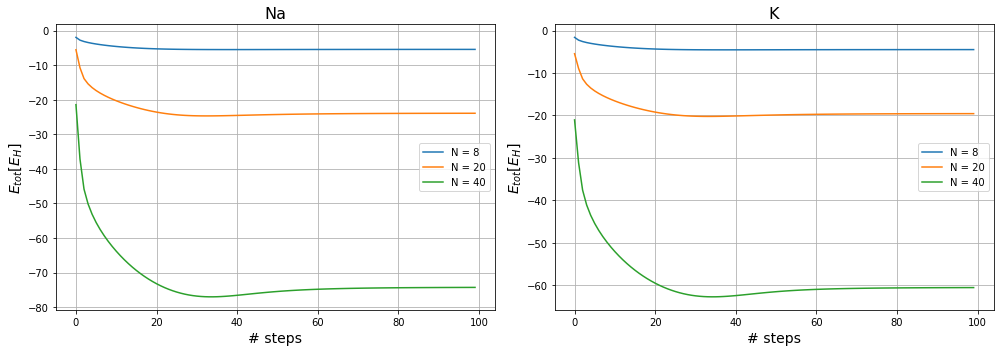

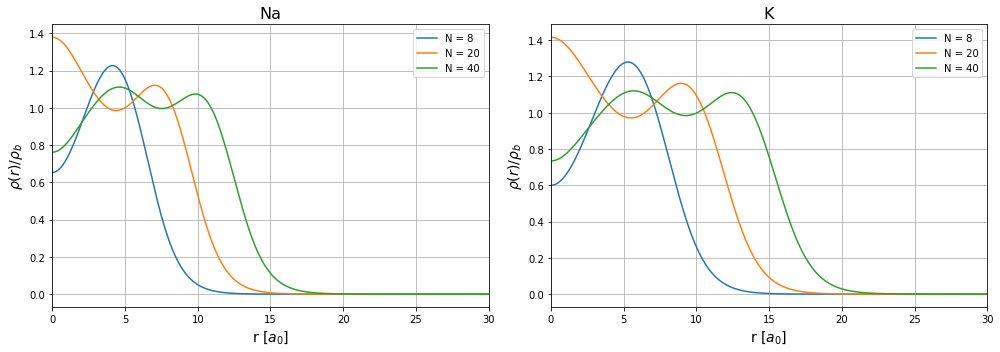

In [10]:
pdf = PdfPages('sf_methods.pdf')

### Plot of energies

plt.figure(figsize = (14, 5))

# Na plots
plt.subplot(121)

for i in range(3):
    plt.plot([i for i in range(steps)], E_Na[i], label=f'N = {N[[1, 3, 4][i]]}')

plt.xlabel('# steps', fontsize=14)
plt.ylabel('$E_{{tot}} [E_H]$', fontsize=14)
plt.title('Na', fontsize=16)
plt.legend()
plt.grid()

plt.subplot(122)
for i in range(3):
    plt.plot([i for i in range(steps)], E_K[i], label=f'N = {N[[1, 3, 4][i]]}')

plt.xlabel('# steps', fontsize=14)
plt.ylabel('$E_{{tot}} [E_H]$ ', fontsize=14)
plt.title('K', fontsize=16)
plt.legend()
plt.grid()

plt.tight_layout()

pdf.savefig()
plt.show()

### Plot of densities

plt.figure(figsize = (14, 5))

# Na plots
plt.subplot(121)

rs = 3.93 # a0
rho_b = 3 / (4*np.pi) / rs**3

for i in range(3):
    plt.plot(rgrid, rho_Na[i]/rho_b, label=f'N = {N[[1, 3, 4][i]]}')
    
plt.xlim(0, 30)
plt.legend()
plt.grid()

plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\\rho(r) / \\rho_b$', fontsize=14)
plt.title('Na', fontsize=16)

# K plots
plt.subplot(122)

rs = 4.86 # a0
rho_b = 3 / (4*np.pi) / rs**3

for i in range(3):
    plt.plot(rgrid, rho_K[i]/rho_b, label=f'N = {N[[1, 3, 4][i]]}')
    
plt.xlim(0, 30)
plt.legend()
plt.grid()

plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\\rho(r) / \\rho_b$', fontsize=14)
plt.title('K', fontsize=16)

plt.tight_layout()

pdf.savefig()
plt.show()

pdf.close()

In [11]:
for i in range(3):
    print(E_Na[i, -1] - E_Na[i, -2], E_K[i, -1] - E_K[i, -2])

0.00019735135470622112 0.00019076669923556722
0.0011864112224451162 0.000989720675693917
0.002883272833642536 0.00218243814042296


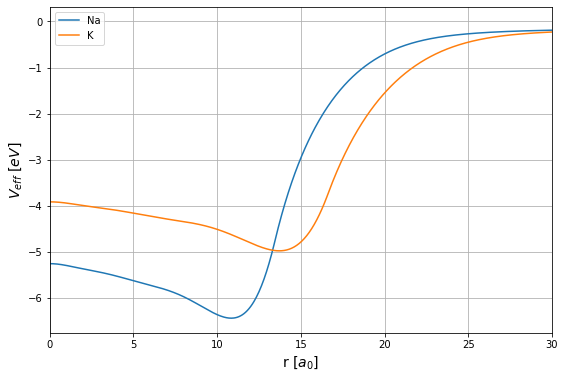

In [12]:
Eh = 27.211386 # Hartee energy: unit energy in eV

pdf = PdfPages('potentials.pdf')

plt.plot(rgrid, (v_ext(rgrid, 3.93, 40, 0) + v_SF(rgrid, rho_Na[2]))*Eh, label='Na')
plt.plot(rgrid, (v_ext(rgrid, 4.86, 40, 0) + v_SF(rgrid, rho_K[2]))*Eh, label='K')

plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$V_{{eff}}\ [eV]$', fontsize=14)
plt.xlim(0, 30)

plt.legend()
plt.grid()

pdf.savefig()
plt.show()

pdf.close()

## 5. Polarizability

### Na

In [14]:
rs = 3.93 # a0
rho_b = 3 / (4*np.pi) / rs**3

deltaN_Na = np.zeros(3)
alpha_Na = np.zeros(3)

display(Latex('N | $\delta N$ | $\\alpha$(N)'))
for i, n in zip(range(3), [8, 20, 40]):
    Rc = (3*n /  (4*np.pi) / rho_b)**(1/3)
    
    # find index of the closest value to Rc
    idx = np.where(rgrid > Rc)[0][0]
    deltaN_Na[i] = 4*np.pi * simpson(rgrid[idx:]**2*rho_Na[i][idx:], rgrid[idx:])
    alpha_Na[i] = Rc**3 * (1 + deltaN_Na[i] / n)
    
    print(str(n).ljust(2), '|', f'{deltaN_Na[i]:.2f}', '|', f'{alpha_Na[i]:.2f}')

<IPython.core.display.Latex object>

8  | 1.49 | 575.86
20 | 2.93 | 1391.67
40 | 4.97 | 2729.65


### K

In [15]:
rs = 4.86 # a0
rho_b = 3 / (4*np.pi) / rs**3

deltaN_K = np.zeros(3)
alpha_K = np.zeros(3)

display(Latex('N | $\delta N$ | $\\alpha$(N)'))
for i, n in zip(range(3), [8, 20, 40]):
    Rc = (3*n /  (4*np.pi) / rho_b)**(1/3)
    
    # find index of the closest value to Rc
    idx = np.where(rgrid > Rc)[0][0]
    
    deltaN_K[i] = 4*np.pi * simpson(rgrid[idx:]**2*rho_K[i][idx:], rgrid[idx:])
    alpha_K[i] = Rc**3 * (1 + deltaN_K[i] / n)
    
    print(str(n).ljust(2), '|', f'{deltaN_K[i]:.3f}', '|', f'{alpha_K[i]:.3f}')

<IPython.core.display.Latex object>

8  | 1.272 | 1064.358
20 | 2.538 | 2587.213
40 | 4.205 | 5074.294


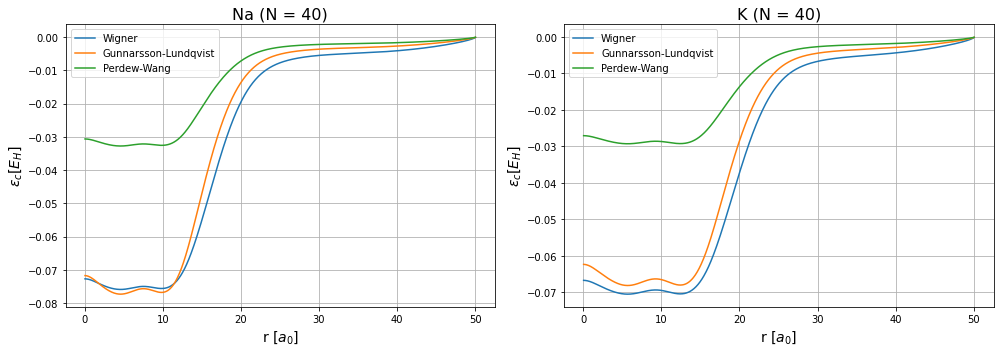

In [18]:
def wigner(rho):
    rs = (3 / (4*np.pi * rho))**(1/3)
    return - 0.88 / (rs + 7.8)


def gunn_lund(rho):
    rs = (3 / (4*np.pi * rho))**(1/3)
    x = rs / 11.4
    
    return -0.0666*((1 + x**3)*np.log(1 + 1/x) - 1/3 + x/2 - x**2)

pdf = PdfPages('correlation.pdf')

### Plot of energies
plt.figure(figsize = (14, 5))

# Na plots
plt.subplot(121)

plt.plot(rgrid, wigner(rho_Na[2]), label='Wigner')
plt.plot(rgrid, gunn_lund(rho_Na[2]), label='Gunnarsson-Lundqvist')
plt.plot(rgrid, G((3 / (4*np.pi * rho_Na[2]))**(1/3)), label='Perdew-Wang')


plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\epsilon_{{c}} [E_H]$', fontsize=14)
plt.title('Na (N = 40)', fontsize=16)
plt.legend()
plt.grid()


# K plots
plt.subplot(122)

plt.plot(rgrid, wigner(rho_K[2]), label='Wigner')
plt.plot(rgrid, gunn_lund(rho_K[2]), label='Gunnarsson-Lundqvist')
plt.plot(rgrid, G((3 / (4*np.pi * rho_K[2]))**(1/3)), label='Perdew-Wang')


plt.xlabel('r [$a_0$]', fontsize=14)
plt.ylabel('$\epsilon_{{c}} [E_H]$', fontsize=14)
plt.title('K (N = 40)', fontsize=16)
plt.legend()
plt.grid()

plt.tight_layout()

pdf.savefig()
pdf.close()